- grafo cujos nodes são os produtos filtrados na interface por categoria simplificada e rede de fast_food
- tamanho dos nodes é proporcional a porção dos produtos
- tamanho das arestas é proporcional a semelhança nutricional de calorias por grama dos produtos

In [2]:
import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import pathlib
import getpass
import networkx as nx
import matplotlib.pyplot as plt

# !pip install pymysql
import pymysql

In [4]:
p = getpass.getpass()
conn = pymysql.connect(host='localhost', port=3306, user='root', passwd = p) 
cur = conn.cursor()

 ·········


In [5]:
cur.execute("USE fast_food;")

0

In [4]:
cur.execute("SHOW tables;")
for r in cur.fetchall():
   print(r)

('address',)
('category',)
('chain',)
('nutricional_units',)
('product',)
('restaurant',)


In [26]:
# simplificar categorias
cur.execute("SELECT * FROM category;") 
for r in cur.fetchall():
   print(r)

(1, 'WHOPPER')
(2, 'MEAT SANDWICH')
(3, 'CHICKEN SANDWICH')
(4, 'VEGGIES')
(5, 'SIDE DISH')
(6, 'SAUCE')
(7, 'ICE CREAM')
(8, 'SHAKES')
(9, 'BREAKFAST')
(10, 'BEEF & PORK')
(11, 'CHICKEN & FISH')
(12, 'SALADS')
(13, 'SNACKS & SIDES')
(14, 'DESSERTS')
(15, 'BEVERAGES')
(16, 'COFFEE & TEA')
(17, 'SMOOTHIES & SHAKES')
(18, 'CROISSANT')
(19, 'HEALTHY BREAD')
(20, 'BAR AND SHORTBREAD')
(21, 'COOKIE')
(22, 'MUFFIN')
(23, 'FAIRTRADE BANANA')
(24, 'OATMEAL')
(25, 'BREAKFAST SANDWICHES & SAVOURY MUFFINS')
(26, 'TOASTIES')
(27, 'SANDWICHES, PANINIS, WRAPS, ROLLS & FOCACCIAS')
(28, 'HOT BOXES')
(29, 'SALAD BOWLS')
(30, 'COFFEE')
(31, 'CAPPUCCINO')
(32, 'MACCHIATO')
(33, ' DOLCE LATTE')
(34, 'MOCHA')
(35, ' MOCHA')
(36, 'DOUBLESHOT ')
(37, 'TEA')
(38, 'CHAI LATTE')
(39, 'REFRESHERS')
(40, 'SMOOTHIE')
(41, ' BLENDED BEVERAGE')
(42, 'OTHERS BEVERAGE')


In [17]:
cur.execute("SELECT * FROM chain;") 
for r in cur.fetchall():
   print(r)

(1, 'BURGER KING')
(2, 'MCDONALDS')
(3, 'STARBUCKS')


In [42]:
cur.execute("SELECT * FROM product LIMIT 5;")
for r in cur.fetchall():
   print(r)

(1, 'WHOPPER', 1, 1, 1, 361)
(2, 'WHOPPER DUPLO', 1, 2, 1, 456)
(3, 'WHOPPER FURIOSO', 1, 3, 1, 386)
(4, 'WHOPPER JR.', 1, 4, 1, 196)
(5, 'WHOPPER JR. BARBECUE BACON', 1, 5, 1, 249)


In [48]:
cur.execute("DESCRIBE product;")
for r in cur.fetchall():
   print(r)

('id_product', 'int', 'NO', 'PRI', None, 'auto_increment')
('name', 'varchar(500)', 'YES', '', None, '')
('chain_id_chain', 'int', 'NO', 'MUL', None, '')
('nutricional_units_id_nutricional_units', 'int', 'NO', 'MUL', None, '')
('category_id_category', 'int', 'NO', 'MUL', None, '')
('serving_size', 'int', 'YES', '', None, '')


In [41]:
query = '''
SELECT COUNT( product.name ) 
FROM product , category
WHERE NOT category.name = 'FAIRTRADE BANANA' ;
'''
cur.execute(query)
for r in cur.fetchall():
   print(r)

(31119,)


In [185]:
query = '''
SELECT p.name AS "product" , p.chain_id_chain AS "chain" , ca.name AS "category" ,
p.serving_size ,(n.calories/p.serving_size) AS "cal_per_gram" , n.id_nutricional_units 
FROM  nutricional_units n 
INNER JOIN product p ON n.id_nutricional_units = p.nutricional_units_id_nutricional_units
INNER JOIN category ca ON p.category_id_category = ca.id_category
WHERE (NOT ca.name = 'FAIRTRADE BANANA');
'''
df = pd.read_sql(query, con=conn, index_col = "product") # convertendo query para um data frame
df = df.drop(["id_nutricional_units"],axis=1) # usado apenas para permitir o JOIN
df.fillna(0,inplace=True) # nan para 0

In [186]:
df 

,chain,category,serving_size,cal_per_gram
product,,,,
WHOPPER,1,WHOPPER,361,1.8753
WHOPPER DUPLO,1,WHOPPER,456,2.1404
WHOPPER FURIOSO,1,WHOPPER,386,2.1710
WHOPPER JR.,1,WHOPPER,196,1.8827
WHOPPER JR. BARBECUE BACON,1,WHOPPER,249,1.7952
...,...,...,...,...
SWEETENED WHIPPED CREAM SHORT - HOT,3,OTHERS BEVERAGE,237,0.2110
SWEETENED WHIPPED CREAM TALL - HOT,3,OTHERS BEVERAGE,355,0.1690
SWEETENED WHIPPED CREAM GRANDE/VENTI® - HOT,3,OTHERS BEVERAGE,473,0.1480


In [187]:
old_cat = df.category.unique()   # simplificando categorias
new_cat= list(old_cat)
for i in range(len(old_cat)):
    if i in [7,13,14,15,16,30,31,32,33,34,35,36,37,38,39,40,41] :
        new_cat[i] = "DRINKS"
    elif i in [3,4,5,6,11,12,28,29]:
        new_cat[i] = "SIDE DISHES"
    else:
        new_cat[i] = "SNACKS AND BREAKFAST"

In [188]:
df.replace(dict(zip(old_cat,new_cat)),inplace=True)

In [189]:
names = {1:"BURGUER KING",2:"MC DONALDS",3:"STARBUCKS"}    # substituindo as redes pelos seus nomes

df.replace({'chain': names},inplace=True)

In [190]:
df.serving_size =  (df.serving_size - df.serving_size.mean()) / df.serving_size.std() # normalizando serving_size
df.serving_size = round(df.serving_size + 2)
df.serving_size.unique()

array([2., 1., 3., 4., 0., 5.])

In [191]:
df_sample = df[df.chain == 'STARBUCKS']
df_sample = df_sample[:20]
df = df_sample

In [210]:
G = nx.Graph()
 # nós
for node in df.index:
    category = df.loc[node,'category']
    if category == "DRINKS" :
        G.add_node( node , color = "orange", size = 100 * df.loc[node,'serving_size'] )
    elif category == "SIDE DISHES" :
        G.add_node( node , color = "green", size = 100 * df.loc[node,'serving_size'] )
    else :
        G.add_node( node , color = "yellow", size = 100 * df.loc[node,'serving_size'] )

 # arestas
for node1 in df.index:
    for node2 in df.index:
        if node1 != node2 and df.loc[node1,'cal_per_gram'] - df.loc[node2,'cal_per_gram'] < 0.0005  : # se eles forem próximos
            G.add_edge( node1 , node2 , color = 'blue', weigh = 1 )
            

In [211]:
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

('BERRY BIRCHER', {'color': 'yellow', 'size': 0.0})
('BERRY BIRCHER', 'OVERNIGHT CHOCOLATE & COCONUT OATS', {'color': 'blue', 'weigh': 1})


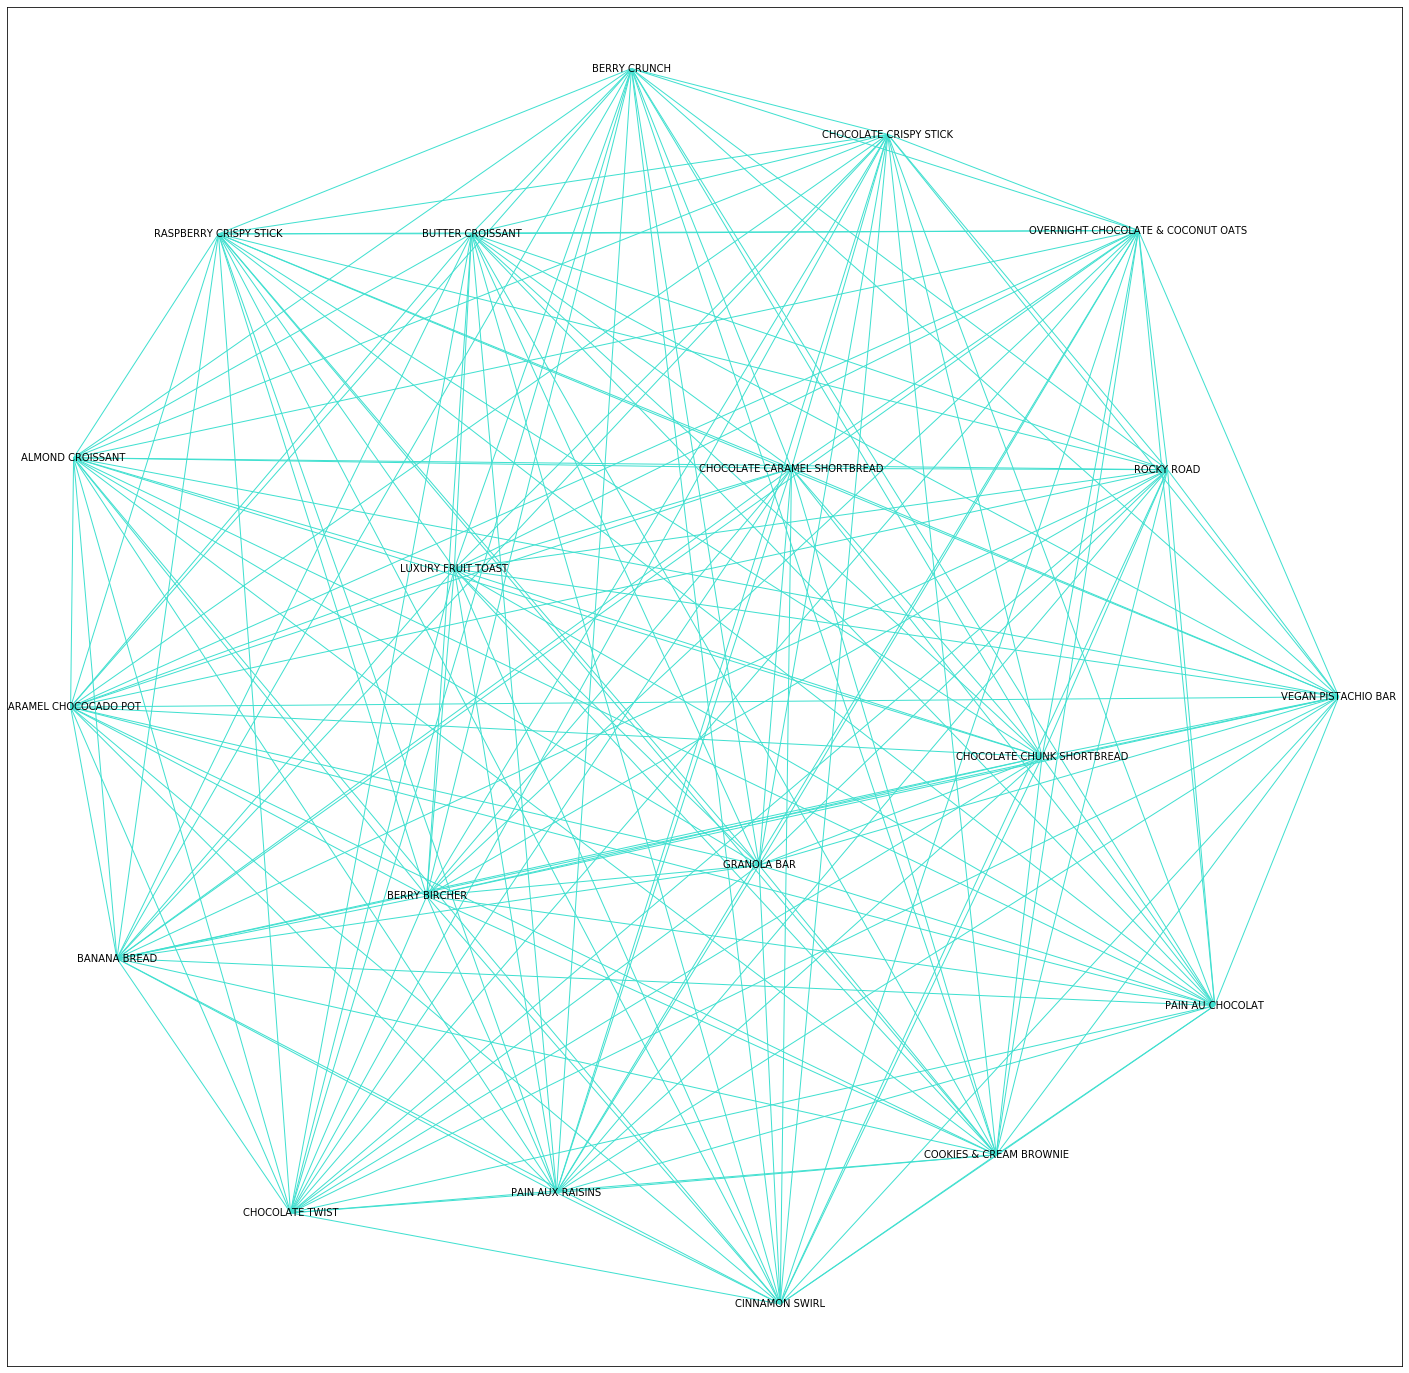

In [212]:
#plotar o grafo        
fig, ax = plt.subplots(figsize=(25,25))

pos = nx.spring_layout(G) 

nx.draw_networkx( G,  #desenhar o grafo (completo)
                  arrows=True,
                  pos=pos,
                  with_labels=True,
                  ax=ax,
                  node_size=[nx.get_node_attributes(G,'size')[g] for g in G.nodes()], 
                  node_shape='o',
                  node_color=[nx.get_node_attributes(G,'color')[g] for g in G.nodes()],
                  alpha=1.0,
                  edge_color = 'turquoise',
                  style='solid',
                  font_size=10,
                  font_color='black',
                  font_weight='normal',
                  font_family='sans-serif')